## Hopfield network - part 1: memory storage and retrieval

Build a Hopfield network with $nunits$ neurons, storing $npatterns$ orthogonal patterns in its synaptic weights.

Neurons activity takes values $S_i=\{\pm1\}$, for $i=1,\ldots,nunits$.

Input patterns take values $\xi_i^\mu=\{\pm1\}$, for $i=1,\ldots,nunits$ neurons and $\mu=1,\ldots,npatterns$ patterns.

Test memory retrieval and the occurrence of spurious states 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
np.random.seed(1)

# plotting specifications
#Options
params = {'text.usetex' : False,
         'font.size' : 20,
         'font.family' : 'cmr10',
#          'figure.autolayout': True
         }
plt.rcParams.update(params)
# plt.rcParams['axes.unicode_minus']=False
plt.rcParams['axes.labelsize']=16
# plt.rcParams['figure.figsize']=(5,5)

cmap = plt.get_cmap("tab10") # default color cycle, call by using color=cmap(i) i=0 is blue
#reversed('RdBu')

## Patterns

- Create $npatterns=4$ orthogonal patterns $\xi_i^\mu$. We visualize neurons on a square grid.
- Create random patterns, with probFlip of having $S_i=+1$.

/tmp/ipykernel_2007/702506753.py:36: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig,ax=plt.subplots(1,nplot,figsize=(20,5))


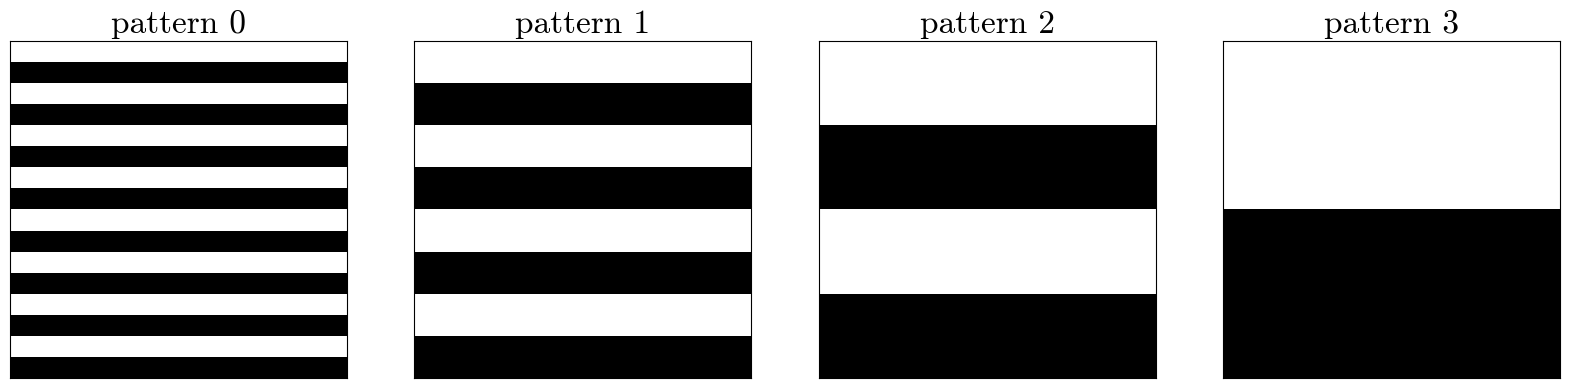

In [13]:
N1=16; # size of edge of square array
nunits=N1**2 # neurons
npatterns=4

def generate_orth_patterns(nunits,npatterns):   # generates othogonal patterns
    train_data=np.zeros((npatterns,nunits))
    N1=int(nunits**(1/2))
    for ip in range(npatterns):
        tempPattern=-np.ones((N1,N1))           # I initialize all to -1
        for i in range(N1):
            if (np.ceil((i+1)/(2**ip)) % 2 ==0):
                tempPattern[i,:]=1 # top left to bottom right
        train_data[ip,:]=tempPattern.flatten()
    return train_data
    
def generate_rand_patterns(nunits,npatterns,probFlip):  # generates non-hortogonal (random) patterns
    #probFlip=probability of having +1 entry
    train_data=-np.ones((npatterns,nunits))     # I initialize all to -1
    N1=int(nunits**(1/2))
    for ip in range(npatterns):
        tempPattern=-np.ones(nunits)
        indflip=(np.random.rand(nunits)<probFlip)
        tempPattern[indflip]=1                  # I flip some
        train_data[ip,:]=tempPattern.flatten()
    return train_data

# plot patterns
def plotpattern(pattern,ax,title='pattern'):
    ax.matshow(np.reshape(pattern,[N1,N1]), cmap='Greys',interpolation='nearest')
    ax.set_xticks([]); ax.set_yticks([]); ax.set_title(title)
    
train_data=generate_orth_patterns(nunits,npatterns)    
#train_data=generate_rand_patterns(nunits,4,0.5)    

nplot=npatterns
fig,ax=plt.subplots(1,nplot,figsize=(20,5))
for i in range(nplot):
    plotpattern(train_data[i],ax[i],title='pattern %s' % i)
if not os.path.exists('Results_hp'):
    os.makedirs('Results_hp')
plt.savefig("Results_hp/orthogonal_patterns4.png")

Compute overlaps $m_{\mu\nu}$ between patterns (correlation): check that orthogonal patterns are orthogonal. Random patterns have small nonzero overlaps.

$$
m_{\mu\nu}={1\over N}\sum_{i=1}^N\xi_i^\mu\xi_i^\nu \ .
$$


In [14]:
def compute_overlap(pattern1,pattern2):
    # returns: overlap between the patterns
    shape1=pattern1.shape
    if shape1 !=pattern2.shape:
        raise ValueError("patterns have different shape!")
    dot_prod=np.dot(pattern1.flatten(),pattern2.flatten())
    return float(dot_prod)/ (np.prod(shape1))

def compute_overlap_list(reference_pattern,pattern_list):   # computes the overlap between one fixed pattern (reference pattern) and a list of patterns
    overlap=np.zeros(len(pattern_list))
    for i in range(0,len(pattern_list)):
        overlap[i]=compute_overlap(reference_pattern,pattern_list[i])
    return overlap

def compute_overlap_matrix(pattern_list):   # computes the overlap between all the patterns of the list
    nr_patterns=len(pattern_list)
    overlap=np.zeros((nr_patterns,nr_patterns))
    for i in range(nr_patterns):
        for k in range(i+1):
            if i==k:
                overlap[i,i]=1
            else:
                overlap[i,k]=compute_overlap(pattern_list[i],pattern_list[k])
                overlap[k,i]=overlap[i,k]
    return overlap

overlap=compute_overlap(train_data[0],train_data[1])
print(overlap)
overlap=compute_overlap_list(train_data[0],train_data)
print(overlap)
overlap=compute_overlap_matrix(train_data)
print(overlap)

0.0
[1. 0. 0. 0.]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Store first pattern in the synaptic weights $w_{ij}$:

$$
w_{ij}={1\over N}\xi^\mu_i\xi^\mu_j-{1\over N}\delta_{ij} \ ,
$$
where the last term enforces $w_{ii}=0$.

/tmp/ipykernel_2007/901952849.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  w_plot=plt.imshow(self,cmap=cm.coolwarm)
/tmp/ipykernel_2007/901952849.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.colorbar(w_plot)
/tmp/ipykernel_2007/901952849.py:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.xlabel("neurons"); plt.ylabel("neurons"); plt.tight_layout(); plt.savefig('Results_hp/'+file)


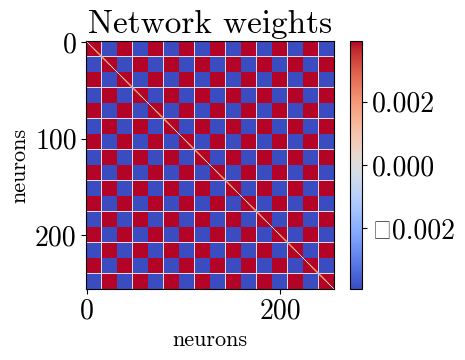

In [15]:
weights0=np.outer(train_data[0],train_data[0])/nunits
np.fill_diagonal(weights0,0)

def plotweights(self,file="current_weight.png"):
    plt.figure(figsize=(5,4))
    w_plot=plt.imshow(self,cmap=cm.coolwarm)
    plt.colorbar(w_plot)
    plt.title("Network weights")
    if not os.path.exists('Results_hp'):
        os.makedirs('Results_hp')
    plt.xlabel("neurons"); plt.ylabel("neurons"); plt.tight_layout(); plt.savefig('Results_hp/'+file)
    plt.show()
    
plotweights(weights0)

## Recurrent dynamics

Implement Hopfield network dynamics, using two different kinds of updates. Monitor the network energy function (Lyapunov function of the dynamics, monotonically decreasing):
$$
E=-{1\over2}\sum_{i,j}w_{ij}S_iS_j \ ,
$$

1. Asynchronous updates at zero temperature. At each time step, pick a random neuron and update its value according to the rule:
$$
S_i(t+1)=sign[\,h_i(t)+\theta_i\,] \ ,
$$ 
where $h_i(t)=\sum_{j=1}^N w_{ij}S_j(t)$ is the neuron's input and $\theta_i$ is an activation threshold.

2. Asynchronous updates with nonzero temperature $T$. At each time step, pick a random neuron and update its value according to the probabilistic rule:
$$
Prob[S_i(t+1)=+1]={1\over 1+e^{-2\beta (h_i(t)+\theta_i)}} \ ,
$$ 
where $h_i(t)=\sum_{j=1}^N w_{ij}S_j(t)$ is the neuron's input and $\theta_i$ is an activation threshold. $\beta=1/T$ is the inverse temperature.

3. Include early stopping for the deterministic dynamics when the energy reaches a minimum.

In [16]:
# dynamics
def probspin(h,beta):           # probabilistic rule
    res=1/(1+np.exp(-2*beta*h))
    return res

def flow(pattern,weights,theta=0.,steps=100,display=True,EarlyStop=True,T=0):
    nunits=len(pattern)
    steps_tot=steps*nunits
    pattern_flat=pattern.flatten()
    energy=[]
    if (type(theta)==float) or (type(theta)==int):
        thetas=np.zeros(len(pattern_flat))+theta
    
    energytemp=0.5*np.dot(np.dot(pattern_flat.T,weights),pattern_flat)
    energy.append(energytemp)
    if display:
        print('initial energy is {}'.format(energytemp))
        
    for step in range(steps_tot):
        units_perm = np.random.permutation(len(pattern_flat))
        for unit1 in units_perm:
            unit_weight=weights[unit1,:]
            net_input = np.dot(unit_weight,pattern_flat)
            if T == 0:
                pattern_flat[unit1]=1 if (net_input > thetas[unit1]) else -1
            else:
                pattern_flat[unit1]=1 if probspin(net_input-thetas[unit1],1/T)>np.random.rand() else -1
        energytemp=0.5*np.dot(np.dot(pattern_flat.T,weights),pattern_flat)
        energy.append(energytemp)       
        if display:
            print('energy at step {} is now {}'.format((step),energytemp))
        if (step>0) & EarlyStop:
            # TOL=np.diff(energy[-nunits*5:-1]).sum()
            TOL=np.diff(energy[-5:-1]).sum()
            if (TOL==0):
                # monitors changes in energy values, stop dynamics if no change in last 5 steps
                if display:
                    print('reached min of energy, stop dynamics!')
                break
    evolved_pattern=pattern_flat
    return evolved_pattern


## Memory retrieval

Introduce a corrupt version $\rho^{\mu}_i(p)$ of the stored pattern $\xi^\mu_i$, where we flip a fraction $p$=flip_fraction of the pattern bits.  

/tmp/ipykernel_2007/2965247989.py:10: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig,ax=plt.subplots(1,2,figsize=(20,5))


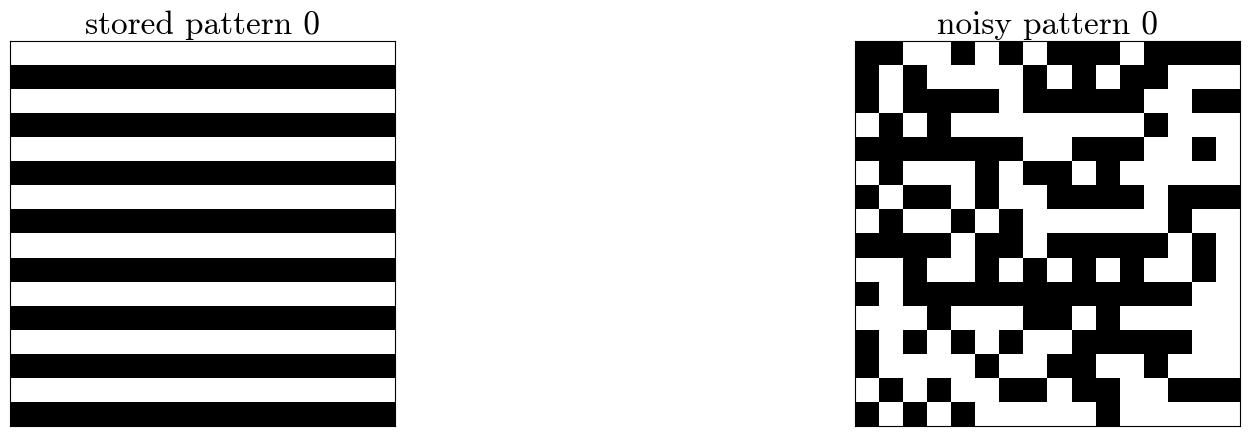

In [ ]:
def noisify(pattern,flip_fraction):
    noisy_pattern=pattern.copy()
    lenpat=len(noisy_pattern)
    choices=np.random.choice(lenpat,int(round(flip_fraction*lenpat)),replace=False)
    noisy_pattern[choices]=-noisy_pattern[choices]
    
    return noisy_pattern

noisy0=noisify(train_data[0],0.3)
fig,ax=plt.subplots(1,2,figsize=(20,5))
plotpattern(train_data[0],ax[0],title='stored pattern 0')
plotpattern(noisy0,ax[1],title='noisy pattern 0')

Use the corrupt pattern $S_i(0)=\rho^{\mu}_i(p)$ as initial condition for the network dynamics. Does the network converge? Try to increase the fraction of bits flipped. When does retrieval stop working? 

Use the negative corrupt pattern $S_i(0)=-\rho^{\mu}_i(p)$ as initial condition, and let the network evolve. Where does the network converge to? 

overlap of noisy pattern with training patterns [-0.3984375 -0.0390625 -0.0703125 -0.0078125]

initial energy is 19.8203125
energy at step 0 is now 127.5
energy at step 1 is now 127.5
energy at step 2 is now 127.5
energy at step 3 is now 127.5
energy at step 4 is now 127.5
reached min of energy, stop dynamics!
overlap of retrieved pattern with training patterns [-1.  0.  0.  0.]

overlap of -noisy pattern with training patterns [0.3984375 0.0390625 0.0703125 0.0078125]

initial energy is 19.8203125
energy at step 0 is now 127.5
energy at step 1 is now 127.5
energy at step 2 is now 127.5
energy at step 3 is now 127.5
energy at step 4 is now 127.5
reached min of energy, stop dynamics!
overlap of retrieved pattern with training patterns [1. 0. 0. 0.]



/tmp/ipykernel_2007/2732654989.py:5: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig,ax=plt.subplots(1,2,figsize=(20,5))
/tmp/ipykernel_2007/2732654989.py:15: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig,ax=plt.subplots(1,2,figsize=(20,5))


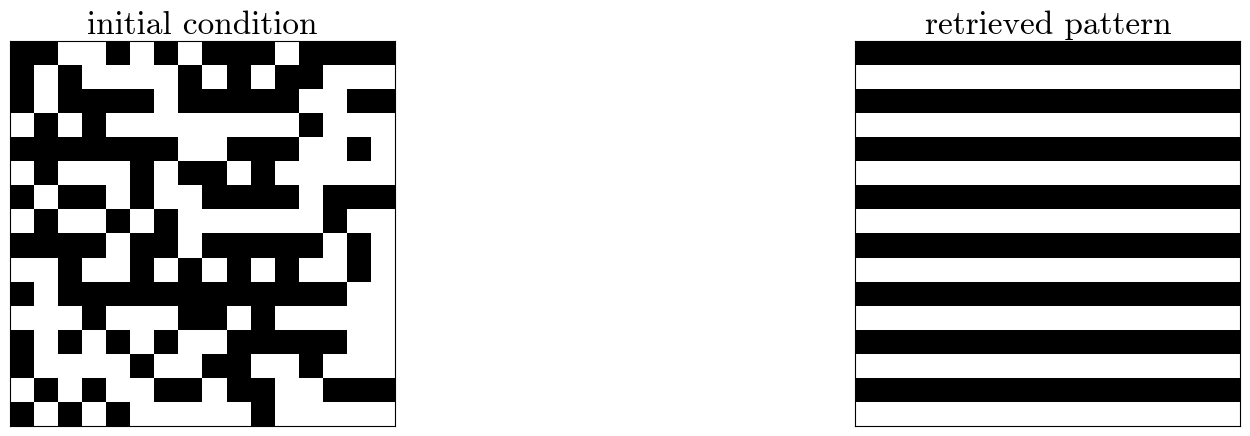

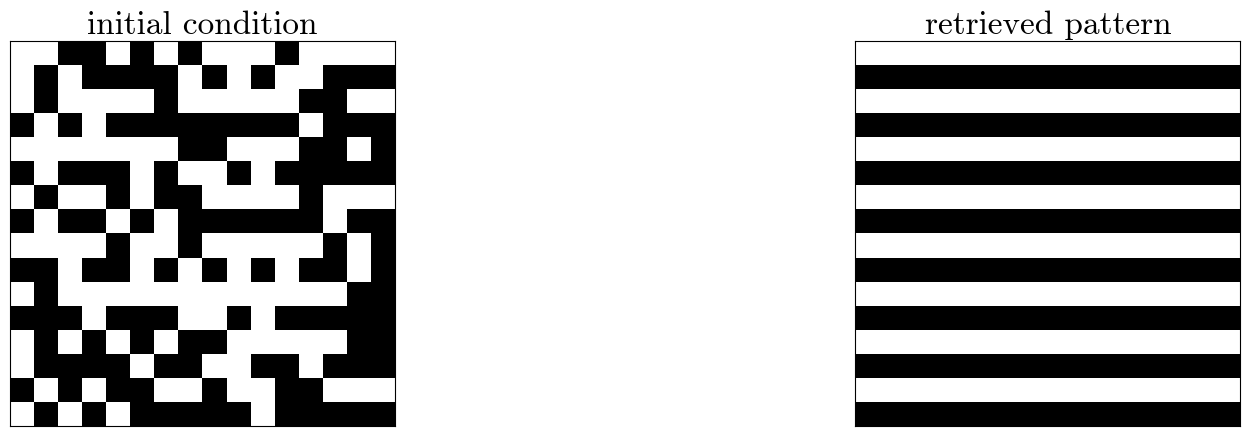

In [27]:
# check pattern is a minimum
overlap=compute_overlap_list(noisy0,train_data)
print('overlap of noisy pattern with training patterns %s\n' % overlap)
noisy_evolved0=flow(noisy0,weights0,theta=0,steps=10000,display=True)
fig,ax=plt.subplots(1,2,figsize=(20,5))
plotpattern(noisy0,ax[0],title='initial condition')
plotpattern(noisy_evolved0,ax[1],title='retrieved pattern')
overlap=compute_overlap_list(noisy_evolved0,train_data)
print('overlap of retrieved pattern with training patterns %s\n' % overlap)

# check -pattern is a minimum
overlap=compute_overlap_list(-noisy0,train_data)
print('overlap of -noisy pattern with training patterns %s\n' % overlap)
noisy_evolved0=flow(-noisy0,weights0,theta=0,steps=1000,display=True)
fig,ax=plt.subplots(1,2,figsize=(20,5))
plotpattern(-noisy0,ax[0],title='initial condition')
plotpattern(noisy_evolved0,ax[1],title='retrieved pattern')
overlap=compute_overlap_list(noisy_evolved0,train_data)
print('overlap of retrieved pattern with training patterns %s\n' % overlap)


## Basin of attraction

Calculate the basin of attraction of the pattern $\xi^\mu_i$, defined as value of the overlap $m[\xi^\mu_i,\rho^{\mu}_i(p)]$ for which pattern retrieval goes down to chance level. For each value of spin flip percentage $p$, run 5 times from random initial conditions and store the fraction of correctly retrieved patterns. 

Hint: calculate retrieval by increasing the percentage of spin flips $p$ of the corrupt initial condition $\rho^{\mu}_i(p)$.


overlap [-1.        -0.796875  -0.6015625 -0.3984375 -0.203125   0.
  0.203125   0.3984375  0.6015625  0.796875 ]
hit rate (retrieval) [0.  0.  0.  0.  0.  0.2 1.  1.  1.  1. ]


/tmp/ipykernel_2007/487936818.py:24: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig,ax=plt.subplots(1,1,figsize=(10,5))
/home/pietromalagoli/anaconda3/envs/uni/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


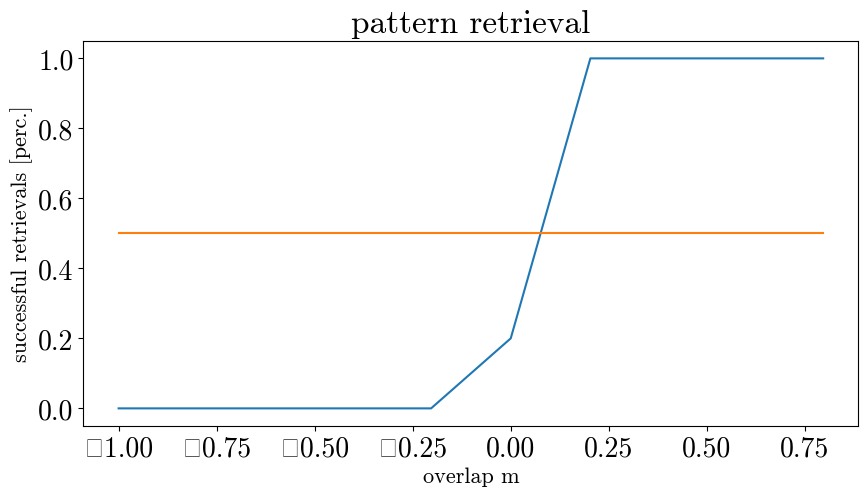

In [28]:
def basin(testpatterns,i_train,weights1,fset,nrepeats,T=0,plotf=True):
    nfset=len(fset) # set of spin flip probability for each initial conditions
    retrieval_f=np.zeros(nfset) # fraction of correct retrievals across repeats
    overlap_f=np.zeros(nfset) # overlaps of initial conditions with stored pattern
    trainpattern=testpatterns[i_train]
    for ifset in range(nfset):      # loop over the number of initial conditions given
        overlap_ic=[]
        count=0
        for icnt in range(nrepeats):
            noisy_pattern=noisify(trainpattern,fset[ifset])
            overlap_ic.append(compute_overlap(noisy_pattern,trainpattern))
            recovered_pattern=flow(noisy_pattern,weights1,T,display=False)
            # estimate overlap with all trained patterns
            overlap=compute_overlap_list(recovered_pattern,testpatterns)
            # count a hit if recovered pattern is the i_train one
            count+=(overlap.argmax()==i_train)
        overlap_f[ifset]=np.array(overlap_ic).mean()
        retrieval_f[ifset]=count/nrepeats

    print('overlap',overlap_f[::-1])
    print('hit rate (retrieval)',retrieval_f[::-1])
    
    if plotf:
        fig,ax=plt.subplots(1,1,figsize=(10,5))
        ax.plot(overlap_f, retrieval_f, linestyle='solid')
        ax.set_title("pattern retrieval")
        ax.set_xlabel("overlap m"); ax.set_ylabel("successful retrievals [perc.]")
        ax.plot([overlap_f.min(),overlap_f.max()],0.5*np.ones(2))

    return overlap_f,retrieval_f

nrepeats=5
fset=np.linspace(0.1,1,10)
test_patterns=np.concatenate((train_data,-train_data),axis=0)
overlap_f,retrieval_f=basin(test_patterns,0,weights0,fset,nrepeats,T=0.)

Store all patterns now, check we recover all of them.

In [29]:
def set_weights(patterns):
    npatterns1,nunits1=patterns.shape
    weights1=np.zeros((nunits1,nunits1))
    for i in range(npatterns1):
        weights1+=np.outer(patterns[i],patterns[i])
    np.fill_diagonal(weights1,0)
    out=weights1/nunits1
    return out

/tmp/ipykernel_2007/901952849.py:6: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  w_plot=plt.imshow(self,cmap=cm.coolwarm)
/tmp/ipykernel_2007/901952849.py:7: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.colorbar(w_plot)
/tmp/ipykernel_2007/901952849.py:11: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.xlabel("neurons"); plt.ylabel("neurons"); plt.tight_layout(); plt.savefig('Results_hp/'+file)


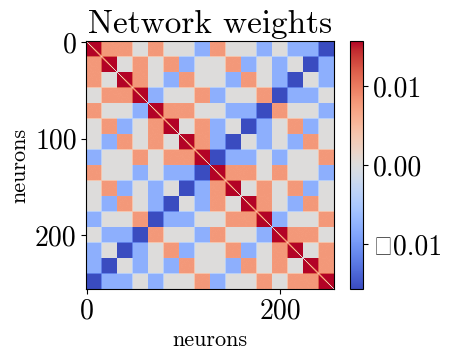

/tmp/ipykernel_2007/623004072.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig,ax=plt.subplots(1,4,figsize=(20,4))
/tmp/ipykernel_2007/623004072.py:20: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig,ax=plt.subplots(1,4,figsize=(20,4))


[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


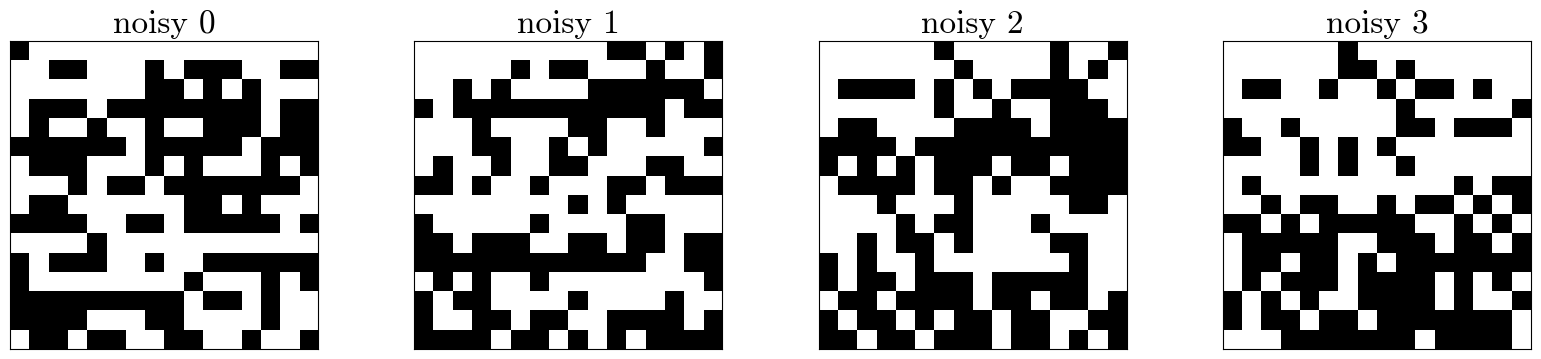

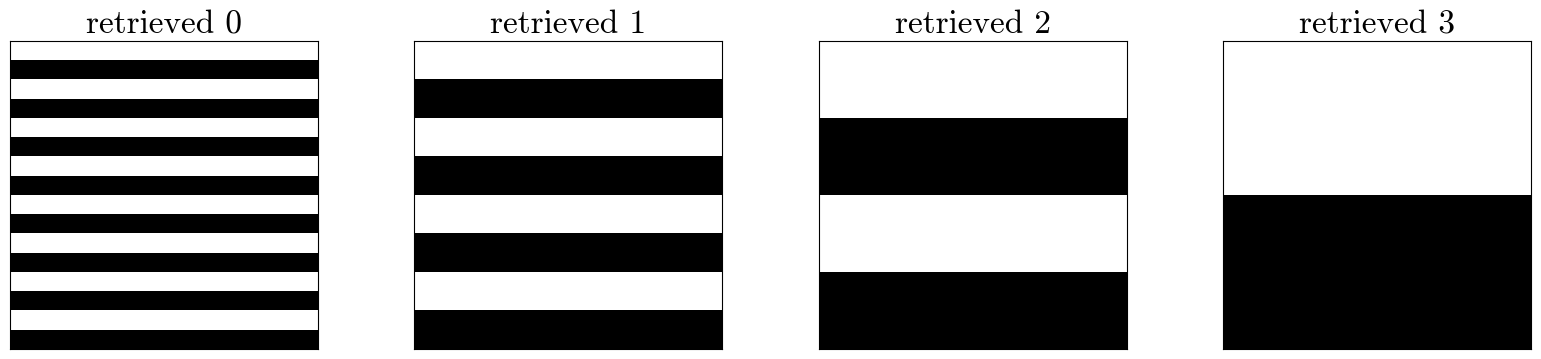

In [30]:
allweights=set_weights(train_data)
plotweights(allweights)

# noisify each pattern
noisy_patterns=np.zeros(train_data.shape)
for i in range(npatterns):
    noisy_patterns[i]=noisify(train_data[i],0.3)

fig,ax=plt.subplots(1,4,figsize=(20,4))
for i in range(npatterns):
    plotpattern(noisy_patterns[i],ax[i],title='noisy %s' % i)

recovered_pattern=np.zeros((npatterns,nunits))
for i in range(npatterns):
    recovered_pattern[i,:]=flow(noisy_patterns[i],allweights,theta=0,steps=50000,display=False)
    overlap=compute_overlap_list(recovered_pattern[i,:],train_data)
    print(overlap)
plt.savefig("hopfield_orth4_noisy.png")

fig,ax=plt.subplots(1,4,figsize=(20,4))
for i in range(npatterns):
    plotpattern(recovered_pattern[i],ax[i],title='retrieved %s' % i)
plt.savefig("hopfield_orth4_retrieval.png")

## Equidistant initial conditions
An initial state that has equal overlap with both patterns ends up in either attractor randomly, 
because asynchronous updates introduce stochasticity.

In [ ]:
pattern01=np.mean([train_data[0],train_data[1]],axis=0)
fig,ax=plt.subplots(1,1,figsize=(6,4))
plotpattern(pattern01,ax,title='pattern01')
overlap=compute_overlap_list(pattern01,train_data)
print('overlaps %s' % overlap)

Run dynamics 10 times and plot retrieved patterns.

In [ ]:
recovered_pattern=np.zeros((10,nunits))
for i in range(10):
    recovered_pattern[i,:]=flow(pattern01,allweights,theta=0,steps=20,display=False)

fig,ax=plt.subplots(1,10,figsize=(20,4))
for i in range(10):
    plotpattern(recovered_pattern[i],ax[i],title='retrieved %s' % i)


## Temperature and basins of attraction

Generate random patterns, store them in the weights.

- Find basin of attraction.

- Check basins of attraction shrink when we increase T.

- Check basins of attraction shrink when we increase the number of patterns.

In [ ]:
# train_data=generate_orth_patterns(nunits,npatterns)    
train_data=generate_rand_patterns(nunits,50,0.5)    

allweights=set_weights(train_data[0:10])
plotweights(allweights)
nrepeats=10
fset=np.linspace(0.05,1,20)
test_patterns=np.concatenate((train_data,-train_data),axis=0)
basin(test_patterns,0,allweights,fset,nrepeats,T=0.)

**Spurious states** 

Combination of 3 patterns!

- Check spurious states are stable at zero temperature. Perturb slightly the spurious state and check it's an attractor.

In [ ]:
spurious=np.sign(train_data[0]+train_data[1]+train_data[2])
overlap=compute_overlap_list(spurious,train_data)
print('overlap %s' % overlap)
spurious_0=noisify(spurious,0.01)
recovered_pattern=flow(spurious_0,allweights,theta=0,steps=30,display=True)
# check that for T>0.46 the spurious state disappears!!
# recovered_pattern=flow(spurious,allweights,theta=0,steps=50000,display=True,T=0.5)
# plot patterns
fig,ax=plt.subplots(1,2,figsize=(6,4))
plotpattern(spurious,ax[0],title='spurious')
plotpattern(recovered_pattern,ax[1],title='retrieved')
plt.savefig("hopfield_orth_spurious.png")
overlap=compute_overlap_list(recovered_pattern,train_data)
print('overlap recovered pattern with training patterns');print(overlap)
print('overlap recovered pattern with spurious state');print(compute_overlap(recovered_pattern,spurious))

Calculate basin of attraction of spurious states. When do spurious states stop being a fixed point?

In [ ]:
# check that spurious states disappear at T=0.46
fset=np.linspace(0,0.5,20)
nrepeats=20
# print(spurious.shape)
# print(train_data.shape)
spurious0=spurious[np.newaxis, :]
test_patterns=np.concatenate((spurious0,train_data,-train_data),axis=0)
basin(test_patterns,0,allweights,fset,nrepeats,T=0.)

## Robustness to brain damage
Set a fraction of the synaptic weights to zero, see how the network performs!

In [ ]:
# train_data=generate_orth_patterns(nunits,4)    
train_data=generate_rand_patterns(nunits,8,0.5)    
allweights=set_weights(train_data)
fracDamage=0.5
nDamage=int(np.array(len(allweights)*fracDamage).round())
indDamage=np.random.permutation(len(allweights))
indDamage=indDamage[0:nDamage]
allweightsDamage=allweights.copy()
allweightsDamage[indDamage]=0
plotweights(allweightsDamage,file="hopfield_weights_damaged.png")
# noisify each pattern
# damaged patterns
noisy_patterns=np.zeros(train_data.shape)
for i in range(npatterns):
    noisy_patterns[i]=noisify(train_data[i],0.1)

fig,ax=plt.subplots(1,4,figsize=(20,4))
for i in range(npatterns):
    plotpattern(noisy_patterns[i],ax[i],title='noisy %s' % i)

recovered_pattern=np.zeros((npatterns,nunits))
for i in range(npatterns):
    recovered_pattern[i,:]=flow(noisy_patterns[i],allweightsDamage,theta=0,steps=50000,display=False)
    overlap=compute_overlap_list(recovered_pattern[i,:],train_data)
    print(overlap.argmax())
plt.savefig("hopfield_orth_damaged_ic.png")

fig,ax=plt.subplots(1,4,figsize=(20,4))
for i in range(npatterns):
    plotpattern(recovered_pattern[i],ax[i],title='retrieved %s' % i)
plt.savefig("hopfield_orth_damaged_retrieval.png")


## Exercise 1:  Hopfield network capacity.

1. Store $p$ random patterns in a network with $N$ units. Each pattern is a random vector $\xi_i^\mu$ with values $\{\pm1\}$ with equal probability.
2. For each pattern $\xi^\mu$, $\mu=1,\ldots,p$, initialize the network with a noisy version $\rho^\mu$ of the pattern $\xi^\mu$ (use noisify and flip_fraction=0.05). Test successful pattern retrieval, namely, whether the retrieved pattern $S_i$ obtained by running the dynamics from initial condition $\rho^\mu$ has the largest overlap with the pattern $\xi^\mu$ among all other stored patterns. For each pattern, attempt retrieval starting from 5 different random initial conditions $\rho^\mu$, and count a success if at least once in 5 the correct pattern $\xi^\mu$ is retrieved (this step is needed because if there's a small basin of attraction for $\xi^\mu$ then it's harder to retrieve the pattern). 
3. As a function of increasing $p$, find the largest $p_{max}$ beyond which a network storing $p$ patterns fails to successfully retrieve all of them: the capacity is then defined as $\alpha_c(N)=p_{max}/N$. Calculate the capacity $\alpha_c(N)$ as a function of increasing $N=10:100$, check that it converges to the theoretical value at large $N$, $\alpha_c=0.138$.

Bonus assignment (optional): improve capacity by replacing the Hebbian weights with the supervised perceptron learning rule (42.9) in [MacKay's book](http://www.inference.org.uk/itprnn/book.pdf).

## Exercise 2:  Basin of attractions of stable states

In this exercise, we will estimate the size of basins of attractions of the network stable fixed points. We start with a Hopfield network storing $p$ random patterns $\xi_i^\mu$ with $N$ units. Fixed points are given by the patterns $\xi_i^\mu$ and their opposite $-\xi_i^\mu$, plus the first spurious states, given by $\xi_i^{sp}=sign(\pm\xi_i^{\mu_1}\pm \xi_i^{\mu_2}\pm \xi_i^{\mu_3})$. Start with $N=100$, $p=10$ random patterns. To estimate the basin of attraction of a fixed point $\xi_i$:
1. Set initial conditions for the dynamics equal to a noisy version $\rho_i(f)$ of the pattern $\xi_i$ (use noisify and flip fraction=$f$)
2. Calculate the overlap between the fixed point and the noisy initial condition $m(f,\mu)={1\over N}\sum_{i=1}^N\xi_i\rho_i^\mu(f)$. Run the dynamics and test whether the intended fixed point was retrieved. For each value of $f$ and each pattern, run dynamics starting from 5 random noisy initial conditions, and estimate the total fraction of correct retrievals.
3. Plot the fraction of correct retrievals as a function of the overlaps $m$ between initial conditions and fixed points. The basin of attraction is defined as the value $m$ where retrieval goes down below $50\%$.

# Question 1: 
For p=10, estimate the average size of the basin of attraction $m$ for the stored patterns $\xi_i^\mu$, for minus the stored patterns $-\xi_i^\mu$ and for the spurious states $\xi_i^{sp}=sign(\pm\xi_i^{\mu_1}\pm \xi_i^{\mu_2}\pm \xi_i^{\mu_3})$. What do you find?

# Question 2: 
So far, we used asynchronous updates in a deterministic network without noise. Introduce a nonzero temperature T with probabilistic updates. For p=10, estimate the critical temperature $T_3$ beyond which the spurious states cannot be retrieved, and the critical temperature $T_c$ beyond which no stored patterns can be retrieved.

# Question 3: 
Calculate $m$ in networks storing an increasingly large number of patterns $p=1:50$. How does $m$ depend on the total number of stored patterns $p$? Is there a value of $p$ for which the size of the basin of attraction goes to zero?

## Hopfield network - part 2: learning

Build a Hopfield network with $nunits$ neurons. Neurons activity takes values $S_i=\{\pm1\}$, for $i=1,\ldots,nunits$.

Input patterns take values $\xi_i^\mu=\{\pm1\}$, for $i=1,\ldots,nunits$ neurons and $\mu=1,\ldots,npatterns$ patterns.

Learn a noisy version of the input patterns using and online Hebbian learning rule. 

For each pattern $\xi_i^\mu$, create $Nnoisy$ corrupted copies $\xi_i^\mu(a)$ of that by flipping bits, for $a=1,\ldots,Nnoisy$.

In [ ]:
train_data=generate_orth_patterns(nunits,4)    
Nnoisy=5*nunits
flipfrac=0.1
train_noisy=np.zeros((npatterns*Nnoisy,nunits))

for ip in range(npatterns):
    for inoisy in range(Nnoisy):
        tempPattern=noisify(train_data[ip],flipfrac)
        train_noisy[inoisy+ip*Nnoisy,:]=tempPattern

for ip in range(npatterns):
    fix,ax=plt.subplots(1,10,figsize=(20,4))
    fig.suptitle('corrupted pattern %s' % ip)
    for inoisy in range(10):
        plotpattern(train_noisy[inoisy+ip*Nnoisy],ax[inoisy],title='')

## Network training [Optional assignment]

Train network with asynchronous updates for $nepochs$ batches. In each training batch, present each one of the noisy patterns $\xi_i^\mu(a)$ to the network, in random order. For each noisy pattern presentation $a$, evolve the asynchronous network dynamics for $trialSteps$ steps with initial conditions equal to the network state $S_i(a-1)$ at the end of the previous presentation, with an external stimulus clamped to the noisy pattern presented, namely the i-th neuron's activation reads:
$$
h_i(t)=\sum_{j=1}^Nw_{ij}S_j(t)+\xi_i^\mu(a)\times stimstrength \ ,\qquad S_i(t+1)=sign (h_i(t)+\theta_i) \ .
$$
Store the network state $S_i(t)$ for $t=1,\ldots,trialSteps$, then update the weights with the Hebbian rule
$$
\Delta w_{ij}={\eta\over N^2} \sum_{t=1}^{trialSteps} S_i(t)S_j(t)-\eta\alpha w_{ij} \ ,\qquad w_{ii}=0\ ,
$$
where $\alpha=1/N$ is a weight decay term.

At each training epoch, test stability of original patterns $\xi_i^\mu$, and stop training when perfect overlap is achieved.